In [1]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
# set path to data in kaggle
data_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'

In [3]:
# image transformations depending on whether it's in train or val
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# load image data
train_data = datasets.ImageFolder(data_path, transform=train_transforms)
val_data = datasets.ImageFolder(data_path, transform=val_transforms)

In [5]:
# the training data consists of 87000, so shortened to 25000
num_train_samples = 25000
val_split = 0.2

index = torch.randperm(num_train_samples)

# randomly split into training and validation 
train_set = torch.utils.data.Subset(train_data, index[int(num_train_samples * val_split):])
val_set = torch.utils.data.Subset(val_data, index[:int(num_train_samples * val_split)])


In [6]:
len(train_set), len(val_set)

(20000, 5000)

In [7]:
# create dataloaders
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_set,batch_size=batch_size,shuffle=False)

In [8]:
classes = train_dataloader.dataset.dataset.classes
print(classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [9]:
base_model = models.resnet50(pretrained=True)

In [10]:
# change fullly connected layer to output matching # of classes
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Linear(num_ftrs, out_features=len(classes))

In [11]:
# freeze all layers besides last one
update_params = []
for name, param in base_model.named_parameters():
    if name in ['fc.weight', 'fc.bias']:
        param.requires_grad == True
        update_params.append(param)
    else:
        param.requires_grad == False

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(update_params, lr=0.001)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
def train_model(model, criterion, optimizer, 
                num_epochs, print_every, 
                train_dataloader, val_dataloader):
    train_losses, val_losses = [], []
    model.to(device)
    batches = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        running_loss = 0
        running_corrects = 0
        
        total_train = 0
        model.train()
        
        # iterate over training data
        for i, (images, labels) in enumerate(train_dataloader):
            batches += 1
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_corrects += (torch.max(outputs, dim=1)[1] == labels).sum()
            total_train += labels.size(0)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # for every # of batches, evaluate the data on the validation set
            if batches % print_every == 0:
                print(f'Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss: {running_loss / batches:.3f}.', end=' ')
                print(f'Train acc: {running_corrects / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in val_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(outputs, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss: {val_loss / len(val_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.')
                
                # track train and validation losses
                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)

        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
    return model, train_losses, val_losses

In [14]:
print_every = 100
num_epochs = 2

resnet, train_losses, val_losses = train_model(
    model=base_model,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    print_every=print_every,
    num_epochs=num_epochs
)

Epoch 0/1
----------
Batch [100]/[625]. Train loss: 1.255. Train acc: 65.250. Val loss: 0.642. Val acc 90.260.
Batch [200]/[625]. Train loss: 0.873. Train acc: 78.750. Val loss: 0.396. Val acc 93.240.
Batch [300]/[625]. Train loss: 0.686. Train acc: 84.323. Val loss: 0.287. Val acc 95.220.
Batch [400]/[625]. Train loss: 0.576. Train acc: 87.195. Val loss: 0.222. Val acc 96.140.
Batch [500]/[625]. Train loss: 0.504. Train acc: 88.988. Val loss: 0.197. Val acc 96.140.
Batch [600]/[625]. Train loss: 0.450. Train acc: 90.188. Val loss: 0.171. Val acc 96.380.
Epoch 1/1
----------
Batch [75]/[625]. Train loss: 0.019. Train acc: 96.375. Val loss: 0.154. Val acc 97.040.
Batch [175]/[625]. Train loss: 0.033. Train acc: 97.268. Val loss: 0.135. Val acc 97.080.
Batch [275]/[625]. Train loss: 0.044. Train acc: 97.273. Val loss: 0.129. Val acc 97.280.
Batch [375]/[625]. Train loss: 0.050. Train acc: 97.450. Val loss: 0.114. Val acc 97.800.
Batch [475]/[625]. Train loss: 0.055. Train acc: 97.526. Va

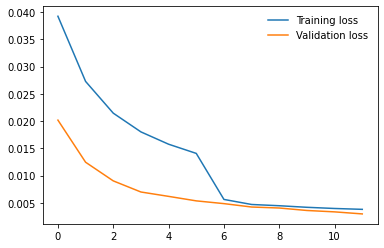

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()